# 7章　多値分類

In [ ]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [49]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [50]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [51]:
# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=4)

## 7.8 データ準備

### データ読み込み

In [52]:
# 学習用データ準備

# ライブラリのインポート
from sklearn.datasets import load_iris

# データ読み込み
iris = load_iris()

# 入力データと正解データ取得
x_org, y_org = iris.data, iris.target

# 結果確認
print('元データ', x_org.shape, y_org.shape)

元データ (150, 4) (150,)


### データ絞り込み

In [55]:
# データ絞り込み

# 入力データに関しては、sepal length(0)とpetal length(2)のみ抽出
x_select = x_org[:,[0,2]]

# 結果確認
print('元データ', x_select.shape, y_org.shape)

元データ (150, 2) (150,)


### 訓練データ・検証データの分割

In [56]:
# 訓練データ、検証データに分割 (シャフルも同時に実施)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_select, y_org, train_size=75, test_size=75, 
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(75, 2) (75, 2) (75,) (75,)


### 訓練データの散布図表示

In [57]:
# データを正解値ごとに分割

x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
x_t2 = x_train[y_train == 2]

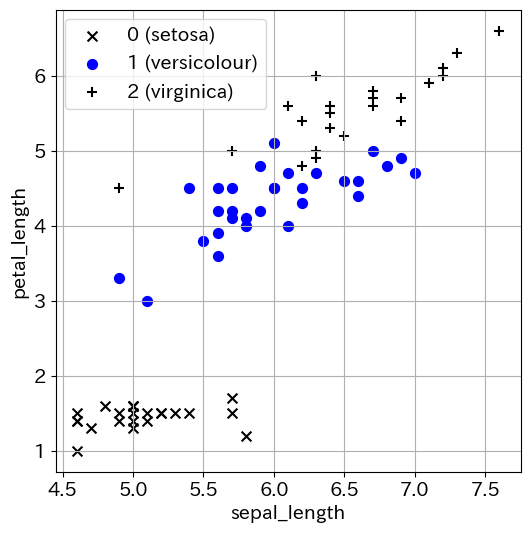

In [58]:
# 散布図の表示

plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='b', s=50, label='1 (versicolour)')
plt.scatter(x_t2[:,0], x_t2[:,1], marker='+', c='k', s=50, label='2 (virginica)')
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.legend()
plt.show()

## 7.9 モデル定義

In [59]:
# 学習用パラメータ設定

# 入力次元数
n_input = x_train.shape[1]

# 出力次元数
# 分類先クラス数　今回は3になる
n_output = len(list(set(y_train)))

# 結果確認
print(f'n_input: {n_input}  n_output: {n_output}')

n_input: 2  n_output: 3


In [60]:
# モデルの定義
# 2入力3出力のロジスティック回帰モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
                
        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的        
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        return x1
    
# インスタンスの生成
net = Net(n_input, n_output)        

### モデル確認

In [61]:
# モデル内のパラメータの確認
# l1.weightが行列にl1.biasがベクトルになっている

for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], requires_grad=True))
('l1.bias', Parameter containing:
tensor([1., 1., 1.], requires_grad=True))


In [62]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=2, out_features=3, bias=True)
)


In [63]:
# モデルのサマリー表示

summary(net, (2,))

/opt/anaconda3/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/opt/anaconda3/lib/python3.9/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [3]                       --
├─Linear: 1-1                            [3]                       9
Total params: 9
Trainable params: 9
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### 最適化アルゴリズムと損失関数

In [64]:
# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

## 7.10 勾配降下法

### データのテンソル化

In [67]:
# 入力変数x_trainと正解値 y_trainのテンソル変数化

inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 検証用変数のテンソル変数化

inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

print(inputs.shape, labels.shape)

torch.Size([75, 2]) torch.Size([75])


### 計算グラフの可視化

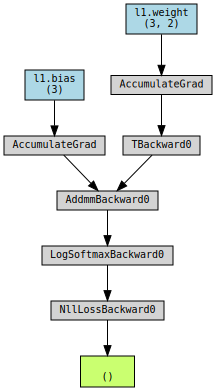

In [66]:
# 予測計算
outputs = net(inputs)

#  損失計算
loss = criterion(outputs, labels)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 予測ラベル値の取得方法

In [ ]:
# torch.max関数呼び出し
# 2つめの引数は軸を意味している。1だと行ごとの集計。
print(torch.max(outputs, 1))

In [ ]:
# ラベル値の配列を取得
torch.max(outputs, 1)[1]

### 繰り返し計算

In [ ]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

In [ ]:
# 繰り返し計算メインループ

for epoch in range(num_epochs):

    # 訓練フェーズ
    
    #勾配の初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()
    
    # パラメータ修正
    optimizer.step()

    # 予測ラベル算出
    predicted = torch.max(outputs, 1)[1]

    # 損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    #予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)

    # 損失計算
    loss_test = criterion(outputs_test, labels_test)

    # 予測ラベル算出
    predicted_test = torch.max(outputs_test, 1)[1]

    # 損失と精度の計算
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)
    
    if ((epoch) % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

## 7.11 結果確認

In [ ]:
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

In [ ]:
# 学習曲線の表示 (損失)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

In [ ]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

### モデルへの入力と出力の確認

In [ ]:
# 正解データの0番目、2番目、3番目

print(labels[[0,2,3]])

In [ ]:
# 該当する入力値を抽出

i3 = inputs[[0,2,3],:]
print(i3.data.numpy())

In [ ]:
# 出力値にsoftmax関数をかけた結果を取得

softmax = torch.nn.Softmax(dim=1)
o3 = net(i3)
k3 = softmax(o3)
print(o3.data.numpy())
print(k3.data.numpy())

### 最終的な重み行列とバイアスの値

In [ ]:
# 重み行列
print(net.l1.weight.data)

# バイアス
print(net.l1.bias.data)

## 7.12 入力変数の4次元化

In [ ]:
# 訓練データ、検証データに分割 (シャフルも同時に実施)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_org, y_org, train_size=75, test_size=75, 
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# 入力次元数
n_input = x_train.shape[1]

In [ ]:
print('入力データ(x)')
print(x_train[:5,:])
print(f'入力次元数: {n_input}')

In [ ]:
# 入力データ x_train と正解データ y_train のテンソル変数化
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 検証用データのテンソル変数化
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

In [ ]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

In [ ]:
for epoch in range(num_epochs):

    # 訓練フェーズ
    
    #勾配の初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()
    
    # パラメータ修正
    optimizer.step()

    #予測値算出
    predicted = torch.max(outputs, 1)[1]

    # 損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    #予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)

    # 損失計算
    loss_test = criterion(outputs_test, labels_test)

    # 予測ラベル算出
    predicted_test = torch.max(outputs_test, 1)[1]

    # 損失と精度の計算
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

In [ ]:
# 損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

In [ ]:
# 学習曲線の表示 (損失)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

In [ ]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

## コラム NLLLoss損失関数

In [ ]:
# 入力変数の準備

# 擬似的な出力データ
outputs_np = np.array(range(1, 13)).reshape((4,3))
# 擬似的な正解データ
labels_np = np.array([0, 1, 2, 0])

# Tensor化
outputs_dummy = torch.tensor(outputs_np).float()
labels_dummy = torch.tensor(labels_np).long()

# 結果確認
print(outputs_dummy.data)
print(labels_dummy.data)

In [ ]:
# NLLLoss関数の呼び出し

nllloss = nn.NLLLoss()
loss = nllloss(outputs_dummy, labels_dummy)
print(loss.item())

## コラム 多値分類モデルの他の実装パターン

### パターン2 モデルクラス側にLogS1oftmax関数を含める

In [ ]:
# モデルの定義
# 2入力3出力のロジスティック回帰モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        # softmax関数の定義
        self.logsoftmax = nn.LogSoftmax(dim=1)
                
        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的        
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.logsoftmax(x1)
        return x2

In [ ]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 損失関数： NLLLoss関数
criterion = nn.NLLLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

In [ ]:
# 予測計算
outputs = net(inputs)

#  損失計算
loss = criterion(outputs, labels)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [ ]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 損失関数： NLLLoss関数
criterion = nn.NLLLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

In [ ]:
for epoch in range(num_epochs):

    # 訓練フェーズ
    
    #勾配の初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()
    
    # パラメータ修正
    optimizer.step()

    #予測ラベル算出
    predicted = torch.max(outputs, 1)[1]

    # 損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    #予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)

    # 損失計算
    loss_test = criterion(outputs_test, labels_test)

    #予測ラベル算出
    predicted_test = torch.max(outputs_test, 1)[1]

    # 損失と精度の計算
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

In [ ]:
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

In [ ]:
# パターン1モデルの出力結果
w = outputs[:5,:].data
print(w.numpy())

# 確率値を得たい場合
print(torch.exp(w).numpy())

### パターン3 モデルクラス側は素のsoftmax

In [ ]:
# モデルの定義
# 2入力3出力のロジスティック回帰モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        # softmax関数の定義
        self.softmax = nn.Softmax(dim=1)
                
        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的        
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.softmax(x1)
        return x2

In [ ]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 損失関数： NLLLoss関数
criterion = nn.NLLLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

In [ ]:
for epoch in range(num_epochs):

    # 訓練フェーズ
    
    #勾配の初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)
    
    # ここで対数関数にかける
    outputs2 = torch.log(outputs)

    # 損失計算
    loss = criterion(outputs2, labels)

    # 勾配計算
    loss.backward()
    
    # パラメータ修正
    optimizer.step()

    #予測ラベル算出
    predicted = torch.max(outputs, 1)[1]

    # 損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    #予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)
        
    # ここで対数関数にかける
    outputs2_test = torch.log(outputs_test)

    # 損失計算
    loss_test = criterion(outputs2_test, labels_test)

    #予測ラベル算出
    predicted_test = torch.max(outputs_test, 1)[1]

    # 対する損失と精度の計算
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

In [ ]:
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

In [ ]:
# パターン2のモデル出力値
w = outputs[:5,:].data.numpy()
print(w)